In [3]:
library(MASS) # required for PCAtest
library(Seurat)
library(dplyr)
library(tidyverse)
library(ICtest) # does bootstrapped analysis of significance of PCA for ICA https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html

# this works in Rstudio but on the notebooks it spits out a 
#library(RGCCA) # regularized CCA vignette here:
# can give significances of individual parts of compenents (I think)
library(PCAtools)

#if (!requireNamespace('BiocManager', quietly = TRUE))
#  install.packages('BiocManager')
#BiocManager::install('PCAtools')

# statistical singificnace from boots trap for PCA https://peerj.com/articles/12967.pdf
library(PCAtest) # devtools::install_github("arleyc/PCAtest")
# avoids axis inversion "In addition, the problem of ‘axis reflection’ (i.e., the arbitrary permutation of
#signs among loadings and PC scores), which is well known in the literature (Jackson,
#1995; Mehlman, Shepherd & Kelt, 1995; Peres-Neto, Jackson & Somers, 2003, 2005), is
#effectively avoided with these two statistics as originally implemented by Vieira (2012) and
#in the R package introduced here"

# another potential contender: https://rdrr.io/github/ucsf-ferguson-lab/syndRomics/man/boot_pca_sample.prcomp.html
# also claims to avoid axis inversion


Loading required package: ggrepel


Attaching package: 'PCAtools'


The following objects are masked from 'package:stats':

    biplot, screeplot




ERROR: Error in library(PCAtest): there is no package called 'PCAtest'


In [4]:
# for bootstrapping significance from PCA
# ICtest library
# https://cran.r-project.org/web/packages/ICtest/ICtest.pdf
# https://cran.r-project.org/web/packages/ICtest/index.html
# https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html
#install.packages('ICtest')

In [5]:
# function for cross validated CCA
#https://rdrr.io/github/giac01/ccatools/man/cca_cv_boot.html
#install.packages('ccatools')

In [36]:
# set paths
# from this pub: https://www.nature.com/articles/s41586-022-04915-7#Sec5
# cell assingments were done with this: 
bugeon.path <- '/space/scratch/Bugeon2022_merfish_ca2plus/'


# Hrvatin, S., Hochbaum, D. R., Nagy, M. A., Cicconet, M., Robertson, K., Cheadle, L., ... & Greenberg, M. E. (2018). 
# Single-cell analysis of experience-dependent transcriptomic states in the mouse visual cortex. Nature neuroscience, 21(1), 120-129.
#From here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5742025/
hrvatin.path <- '/home/acampbell/test_datasets/Hrvatin2018/'

tasic.path <- '/space/scratch/Tasic2018_GSE115746/'

In [41]:
# functions


pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  # Almost as Seurat::NormalizeData but we use log2 rather than natural log
  # from here https://satijalab.org/seurat/reference/normalizedata
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts # Feature counts for each cell are divided by the total counts for that cell...
  x <- x*scale_factor # and multiplied by the scale.factor. 
  # the we log2 plus 1 rather than natural log plus 1 seurat uses
  return(log2(x+1))
}

pavlab.normalize <- function(df, UMI = NULL, median.scale=FALSE, scaleby = 10000){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if(median.scale){ scaleby = median(UMI)}
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
    #
    df[] <- Map(pseudocount_log2p1_transform, df, scale_factor = scaleby, UMI.provided = UMI)
    
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


In [7]:
hrvatin2018.meta <- read.csv(paste(hrvatin.path,'GSE102827_cell_type_assignments.csv.gz', sep = ''))
head(hrvatin2018.meta)

,X,stim,sample,maintype,celltype,subtype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,x2_35_0_bc0013,0h,B1_1_0h,Excitatory,ExcL4,ExcL4_3
2,x2_35_0_bc0014,0h,B1_1_0h,Excitatory,ExcL5_3,NA
3,x2_35_0_bc0016,0h,B1_1_0h,Excitatory,ExcL5_2,NA
4,x2_35_0_bc0017,0h,B1_1_0h,Excitatory,ExcL6,NA
5,x2_35_0_bc0018,0h,B1_1_0h,Excitatory,ExcL5_3,NA
6,x2_35_0_bc0019,0h,B1_1_0h,Excitatory,ExcL23,ExcL23_1


In [9]:
table(hrvatin2018.meta$celltype)


     Astro     Endo_1     Endo_2     ExcL23      ExcL4    ExcL5_1    ExcL5_2 
      7039       3327        123       2963       3198       1976        410 
   ExcL5_3      ExcL6        Hip    Int_Cck    Int_Npy     Int_Pv  Int_Sst_1 
      1407       3276        137         91        137        227        174 
 Int_Sst_2    Int_Vip Macrophage    Micro_1    Micro_2      OPC_1      OPC_2 
       181        126        537        549       9609       1725        101 
    Olig_1     Olig_2     Olig_3     Olig_4     Olig_5     Olig_6     Olig_7 
       610        964        846       4047        747        786        630 
  Pericyte        RSP       SM_1       SM_2        Sub 
       782        420        323        298        500 

In [ ]:
# cell types in figure 1f Int_Cck, Int_Npy, Int_Pv, Int_Sst_1, Int_Sst_2, Int_Vip

In [17]:
hrvatin2018.counts<-read.csv(paste(hrvatin.path, 'GSE102827_merged_all_raw.csv.gz',sep=''))

In [18]:
dim(hrvatin2018.counts)

[1] 25187 65540

In [22]:
rownames(hrvatin2018.counts) <- hrvatin2018.counts$X

In [23]:
# sum(is.na(hrvatin2018.counts)) #this will show no na's
hrvatin2018.counts <- hrvatin2018.counts[,2:dim(hrvatin2018.counts)[2]]

In [25]:
head(hrvatin2018.counts)

,x2_35_0_bc0013,x2_35_0_bc0014,x2_35_0_bc0016,x2_35_0_bc0017,x2_35_0_bc0018,x2_35_0_bc0019,x2_35_0_bc0020,x2_35_0_bc0021,x2_35_0_bc0022,x2_35_0_bc0023,...,x2_98_4_2_2_bc2741,x2_98_4_2_2_bc2751,x2_98_4_2_2_bc2753,x2_98_4_2_2_bc2769,x2_98_4_2_2_bc2779,x2_98_4_2_2_bc2789,x2_98_4_2_2_bc2805,x2_98_4_2_2_bc2823,x2_98_4_2_2_bc2857,x2_98_4_2_2_bc2997
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0610007P14Rik,0,0,1,0,0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0610009E02Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009O20Rik,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,3,0,2,1,1,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
hrvatin2018.meta$umi <- colSums(hrvatin2018.counts)
print(hrvatin2018.meta$umi[1:10])
hrvatin2018.umi.medianforscalefactor <- median(hrvatin2018.meta$umi)
print(hrvatin2018.umi.medianforscalefactor)

 [1] 14375 13739 13497 14740 13830 13385 11842 11803 11716 13750
[1] 2027


In [40]:
hrvatin.inhibitory.idx <- grep('Int', hrvatin2018.meta$celltype)
length(hrvatin.inhibitory.idx)


[1] 936

In [65]:
bugeon2022.genes <- as.list(read.table(paste(bugeon.path,'genes.names.txt',sep ='')))
bugeon2022.genes <- bugeon2022.genes$V1
print(length(bugeon2022.genes))
bugeon2022.genes
# spearmen rank correlation between Bugeon genes and PC1 ranking of them from Hrvatin or Taisic

[1] 72


[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [61]:
bugeon2022.genes

In [64]:
tPC1.bugeon2022 %in% bugeon2022.genes$V1

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[25]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
[37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

In [78]:
tPC1.bugeon2022[!(tPC1.bugeon2022 %in% bugeon2022.genes)]

[1] "Gnn3a"

In [42]:
hrvatin.counts.inhibitory <- hrvatin2018.counts[,hrvatin.inhibitory.idx]
hrvatin.counts.inhibitory.normed <- pavlab.normalize(hrvatin.counts.inhibitory, 
                                                     UMI=hrvatin2018.meta$umi[hrvatin.inhibitory.idx], 
                                                     scaleby = hrvatin2018.umi.medianforscalefactor)

In [58]:
hrvatin.counts.inhibitory.normed <- as.data.frame(scale(t(hrvatin.counts.inhibitory.normed)))
rownames(hrvatin.counts.inhibitory.normed) <- colnames(hrvatin.counts.inhibitory)
colnames(hrvatin.counts.inhibitory.normed) <- rownames(hrvatin.counts.inhibitory)

In [58]:
#GSE115746_accession_table.csv.gz  GSE115746_cells_exon_counts.csv.gz  GSE115746_complete_metadata_28706-cells.csv.gz  GSE115746_controls_exon_counts.csv.gz

In [59]:
hrvatin.inhib.pca <- pca(hrvatin.counts.inhibitory.normed)

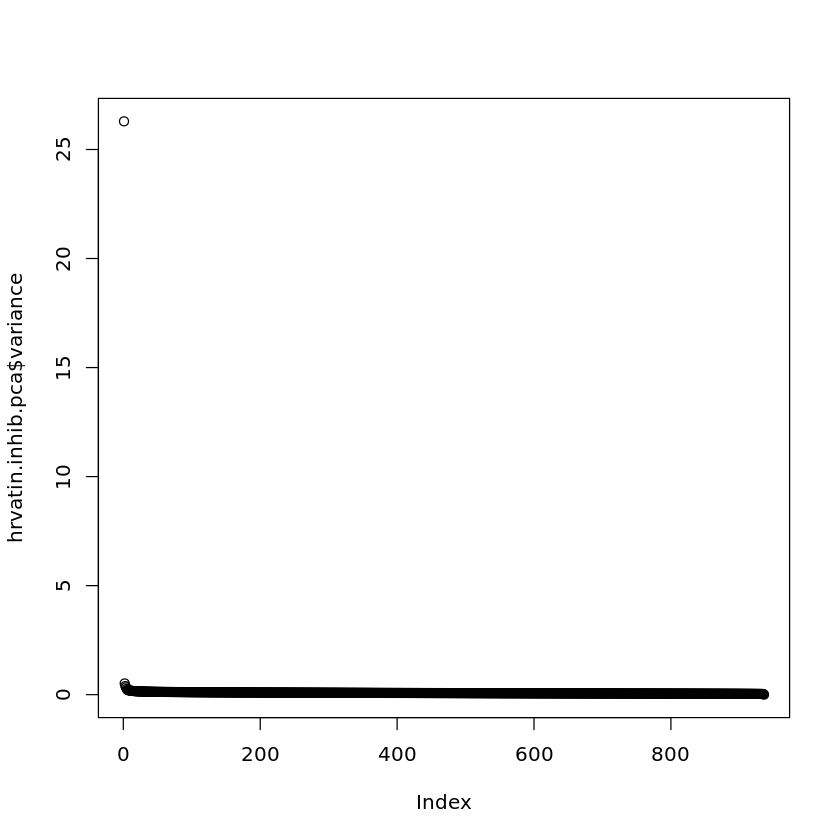

In [88]:
plot(hrvatin.inhib.pca$variance)

In [93]:
tPC1_fromrnaseq.hrvatingenes <- data.frame(gene = colnames(hrvatin.counts.inhibitory.normed), tPC1=hrvatin.inhib.pca$rotated$PC1) %>%
    arrange(tPC1)
print(dim(tPC1_fromrnaseq.hrvatingenes ))
head(tPC1_fromrnaseq.hrvatingenes)

[1] 25187     2


,gene,tPC1
,<chr>,<dbl>
1,Ndrg4,-29.44504
2,Snap25,-29.10790
3,Atp1b1,-28.55170
4,Calm2,-27.94055
5,Ppia,-27.68914
6,Tspyl4,-27.61248


In [112]:
tPC1_fromrnaseq.bugeongenes <- tPC1_fromrnaseq.hrvatingenes[tPC1_fromrnaseq.hrvatingenes$gene %in% bugeon2022.genes,]
tPC1_fromrnaseq.bugeongenes 

,gene,tPC1
,<chr>,<dbl>
34,Slc6a1,-24.61856
48,Serpini1,-24.16568
275,Satb1,-20.71906
543,Rasgrf2,-19.30147
559,Pvalb,-19.24926
651,Gad1,-18.92433
1204,Sst,-17.54816
1275,Cdh13,-17.43823
1328,Rab3c,-17.34893


In [76]:
#gene order of bugeon tPC1
tPC1.bugeon2022 <- c("Pvalb","Slc6a1","Gad1","Lhx6","Serpini1","Tac1","Npy","Cox6a2",
                    "Gabrd","Rgs4","Cort","Prkca","Crhbp","Sst","Satb1","Calb1","Ntng1",
                    "Col25a1","Rasgrf2","Nrn1","Rab3c", "Bcl11b","Cdh13","Neurod6","Enpp2",
                    "Hapln1","Wfs1","Pthlh","Lamp5","Kcnk2","Thsd7a","Aldoc","Gnn3a","Plcxd2",
                    "Slc17a8","Plp1","Th","Chodl","Nr4a2","Nos1","Cpne5","Chrm2","Gda",
                    "Nov","Npy2r","Sema3c","Ndnf","Sncg","Kctd12","Pcp4","Calb2","Trp53i11",
                    "Cck","Rgs10","Pde1a","Cryab","Crh","Cadps2","Pnoc","Synpr","Id2","Rgs12",
                    "Snca","Penk","Kit","Cplx2","Reln","Tac2","Htr3a","Vip","Cnr1","Cxcl14")

In [113]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromrnaseq.bugeongenes$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromrnaseq.bugeongenes$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

In [120]:
tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin <- rank.tPC1.from_rnaseq
tPC1_fromrnaseq.bugeongenes$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromrnaseq.bugeongenes$gene <- as.factor(tPC1_fromrnaseq.bugeongenes$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

In [121]:
head(tPC1_fromrnaseq.bugeongenes)

,gene,tPC1,rank_in_hrvatin,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
34,Slc6a1,-24.61856,1,5
48,Serpini1,-24.16568,2,1
275,Satb1,-20.71906,3,6
543,Rasgrf2,-19.30147,4,15
559,Pvalb,-19.24926,5,2
651,Gad1,-18.92433,6,19


In [123]:
cor.test( tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin,  tPC1_fromrnaseq.bugeongenes$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin and tPC1_fromrnaseq.bugeongenes$rank_in_bugeon
S = 29142, p-value = 7.09e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5113682 


So we have a good correlation when we use all the genes in Hrvatin, rember that this is a highly abnormal dataset,
these mice have been darkhoused for 2 months.

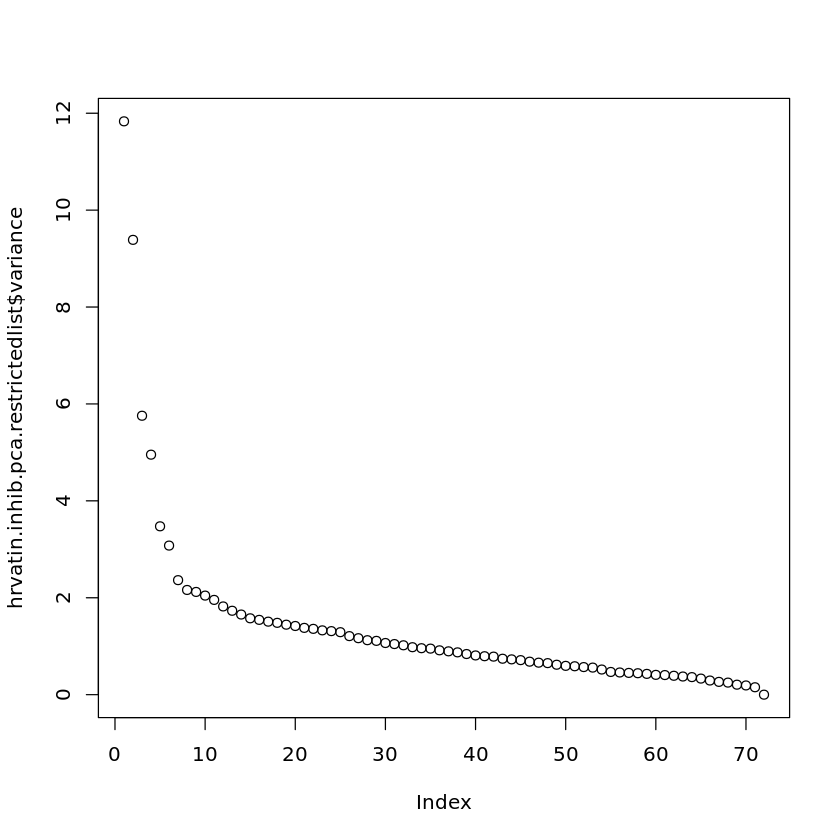

In [124]:
# and if we calculate it with just the bugeon genes for the pca?
hrvatin.inhib.pca.restrictedlist <- pca(hrvatin.counts.inhibitory.normed[,bugeon2022.genes])
plot(hrvatin.inhib.pca.restrictedlist$variance)

In [126]:
colnames(hrvatin.counts.inhibitory.normed[,bugeon2022.genes])

[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

[1]  -2.82506703  -2.31937756  -3.87936504  19.25266564   6.59230668
 [6] -12.94322567  22.27348269   7.10586513   7.74885082  -9.50905850
[11]   2.16861354   7.20842263  -0.91308377   2.30461563  13.18832181
[16]  -2.15499471  16.97779051 -13.53371908 -10.60298812  -5.00933415
[21]  -2.61509338 -13.21384651  -0.01857760  22.71044521 -12.78387405
[26]  -6.82623003 -18.87061205   7.47116049   0.91018298 -18.07080579
[31] -14.94058086  16.67829094  -4.28366286   1.83417741   4.58470990
[36] -10.30201493  -5.70385890  -0.04900924   3.22536879   2.69124326
[41]   3.97320025   3.31320500  13.55634792   0.68489063 -10.13474656
[46]   1.28393396 -17.15778426  -9.81297735  -0.84916817   4.21731503
[51] -15.12778467  -1.13803773   5.66646823  -8.14971483  -8.28822803
[56]   5.71106892  24.51565764 -11.88243321   7.35240106   2.02681165
[61]  -8.68870867 -10.72546849  -3.21126767  26.67113847  13.64253645
[66]   4.67536079  -6.39433173   3.60436683   3.62164685  -3.53103650
[71]  -5.98000861   2.99721259

In [129]:
tPC1_fromrnaseq.hrvatingenes <- data.frame(gene = colnames(hrvatin.counts.inhibitory.normed[,bugeon2022.genes]),
                                           tPC1 = hrvatin.inhib.pca.restrictedlist$rotated$PC1) %>% arrange(tPC1)
    
print(dim(tPC1_fromrnaseq.hrvatingenes ))
tPC1_fromrnaseq.hrvatingenes

[1] 72  2


gene,tPC1
<chr>,<dbl>
Id2,-18.870612
Kit,-18.070806
Pnoc,-17.157784
Rab3c,-15.127785
Lamp5,-14.940581
Cryab,-13.533719
Gad1,-13.213847
Cck,-12.943226
Hapln1,-12.783874


In [130]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromrnaseq.bugeongenes$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromrnaseq.bugeongenes$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

In [131]:
tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin <- rank.tPC1.from_rnaseq
tPC1_fromrnaseq.bugeongenes$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromrnaseq.bugeongenes$gene <- as.factor(tPC1_fromrnaseq.bugeongenes$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

[1] "34"    "48"    "275"   "543"   "559"   "651"   "1204"  "1275"  "1328" 
[10] "1479"  "1504"  "1544"  "1573"  "1693"  "1931"  "1947"  "1954"  "2797" 
[19] "3063"  "3450"  "3487"  "3614"  "3646"  "3818"  "3843"  "3849"  "4143" 
[28] "4182"  "4201"  "4309"  "4424"  "4600"  "4644"  "4964"  "4991"  "5067" 
[37] "5096"  "5209"  "5493"  "5618"  "5755"  "6250"  "6303"  "6491"  "7140" 
[46] "7277"  "7360"  "7409"  "8074"  "8137"  "8172"  "8746"  "8793"  "8865" 
[55] "9035"  "9097"  "9155"  "9548"  "10250" "10320" "10335" "10385" "10560"
[64] "10671" "10795" "11144" "11209" "11380" "11518" "12184" "12308" "12597"

In [132]:
head(tPC1_fromrnaseq.bugeongenes)

,gene,tPC1,rank_in_hrvatin,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
34,Slc6a1,-24.61856,1,5
48,Serpini1,-24.16568,2,1
275,Satb1,-20.71906,3,6
543,Rasgrf2,-19.30147,4,15
559,Pvalb,-19.24926,5,2
651,Gad1,-18.92433,6,19


In [133]:
cor.test( tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin,  tPC1_fromrnaseq.bugeongenes$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin and tPC1_fromrnaseq.bugeongenes$rank_in_bugeon
S = 29142, p-value = 7.09e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5113682 


So the rank correlation is 0.5 between both datasets for the ordering on  PC1 of the gtranscriptomic data in Hrvatin and Bugeon.
with decent significance.  Enough to pass a bonferroni threshold for a number of tests.  You can also note Just by lookuing at the major cell type markers in the PCs that they oppose one another, espescially in the restricted list PC.  This is just from less than 1000 cells between the two datasets as well.

In [135]:
list.files(tasic.path)

[1] "GSE115746_accession_table.csv.gz"              
[2] "GSE115746_cells_exon_counts.csv.gz"            
[3] "GSE115746_complete_metadata_28706-cells.csv.gz"
[4] "GSE115746_controls_exon_counts.csv.gz"

In [137]:
library(data.table)


Attaching package: 'data.table'


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:dplyr':

    between, first, last




In [144]:
tasic2018.meta <- read_csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv.gz',sep=''))

In [146]:
tasic.path

[1] "/space/scratch/Tasic2018_GSE115746/"

In [147]:
tasic2018.meta <-read.csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv', sep = ''))
head(tasic2018.meta )

,sample_name,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,...,sequencing_tube,sequencing_batch,sequencing_qc_pass_fail,cell_class,cell_subclass,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,F0S4_150820_019_A01,F0S4_150820_019_A01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322881,GSM3189899,Control: 1E-8 ERCC MIX1_1
2,F0S4_150820_019_B01,F0S4_150820_019_B01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323629,GSM3189901,Control: No Template Control_1
3,F0S4_150820_019_C01,F0S4_150820_019_C01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322992,GSM3189899,Control: 1E-8 ERCC MIX1_1
4,F0S4_150820_019_D01,F0S4_150820_019_D01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323740,GSM3189901,Control: No Template Control_1
5,F0S4_150820_019_E01,F0S4_150820_019_E01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7321958,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1
6,F0S4_150820_019_F01,F0S4_150820_019_F01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7322069,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1


In [143]:
'GSE115746_cells_exon_counts.csv'

[1] "/space/scratch/Tasic2018_GSE115746/"

In [178]:
# loading tasic, currently this file is only 78 genes worth of data it has not uploaded properly
tasic.exon.counts <- read.csv(paste(tasic.path,'GSE115746_cells_exon_counts.csv.gz',sep = ''))
print(dim(tasic.exon.counts))
head(tasic.exon.counts)

[1] 45768 23179


,X,F2S4_150422_002_A01,F2S4_150422_002_B01,F2S4_150422_002_C01,F2S4_150422_002_D01,F2S4_150422_002_E01,F2S4_150422_002_F01,F2S4_150422_002_G01,F2S4_150422_002_H01,F2S4_150427_001_A01,...,F1S4_180124_316_G01,F1S4_180124_316_H01,F1S4_180124_317_A01,F1S4_180124_317_B01,F1S4_180124_317_C01,F1S4_180124_317_D01,F1S4_180124_317_E01,F1S4_180124_317_F01,F1S4_180124_317_G01,F1S4_180124_317_H01
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
2,0610006L08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0610007P14Rik,95,48,101,51,36,128,126,102,64,...,105,139,103,205,88,172,27,108,23,168
4,0610009B22Rik,68,47,43,42,58,14,27,68,19,...,41,86,271,118,101,174,102,121,111,119
5,0610009E02Rik,0,0,11,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,7
6,0610009L18Rik,6,7,0,0,26,8,4,0,0,...,0,0,0,12,10,16,12,0,0,5


In [179]:
rownames(tasic.exon.counts) <- tasic.exon.counts$X
tasic.exon.counts <- tasic.exon.counts[,c(2:dim(tasic.exon.counts)[2])]

In [194]:
length(colnames(tasic.exon.counts))

[1] 23178

In [164]:
#sapply(as.character(jeager2018_meta$source_name), function(y) if (grepl("_F_", y, fixed=TRUE)) "Fos+" else "Fos-"  )
sum(sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) ))

[1] 10556

In [213]:
# index's to get the V1 gabanergic cells we want
tasic.GABAergic.idx <- sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) )
tasic.V1.idx <- tasic2018.meta$source_name == 'Primary Visual Cortex (VISp)'
tasic2018v1_inhibitory.meta <- tasic2018.meta[tasic.V1.idx &  tasic.GABAergic.idx,]
dim(tasic2018v1_inhibitory.meta)
#

[1] 6147   25

In [214]:
# there are some cell types that weren't present in Bugeon probably due to the limits of coppaFISH
# Meis2 and Serpinf1 seem rare, also the unamed cells will be thrown out
table(tasic2018v1_inhibitory.meta$cell_subclass)


            Lamp5    Meis2    Pvalb Serpinf1     Sncg      Sst      Vip 
      22     1122       45     1337       27      125     1741     1728 

In [215]:
# filtering
gabacellsubclass.keepers <- c("Lamp5","Pvalb","Sncg","Sst","Vip")
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$cell_subclass %in% gabacellsubclass.keepers,]
dim(tasic2018v1_inhibitory.meta)

[1] 6053   25

In [217]:
# filter toe make sure we have matching metadata and count data, the coutsn contain some contorl samples we wont use
v1gaba.cells.idx <- colnames(tasic.exon.counts) %in% tasic2018v1_inhibitory.meta$sample_name
tasic2018.v1_inhibitory.exon.counts <- tasic.exon.counts[,v1gaba.cells.idx]
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$sample_name %in% colnames(tasic2018.v1_inhibitory.exon.counts),]
print(dim(tasic2018.v1_inhibitory.exon.counts))
print(dim(tasic2018v1_inhibitory.meta))

[1] 45768  5663
[1] 5663   25


In [219]:
getwd()

[1] "/home/acampbell/PavLabEngrams/IEG_gradients"

[1] 1 3 2